In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
%matplotlib inline
from finrl.config_tickers import SP_500_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from settings import *
from pprint import pprint
import sys
import os
import itertools
import json

if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

sys.path.append("../FinRL-Library")


In [2]:
INDICATORS = ['macd',
               'rsi_30',
               'cci_30',
               'dx_30']

with open("data/stock.json") as f:
    list_tickers = list(json.load(f).keys())

In [3]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = list_tickers).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (251700, 8)


In [4]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [5]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 50, State Space: 301


In [14]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

In [6]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

In [7]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [8]:
df_trade_date = pd.DataFrame({'data':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, pd.DataFrame(temp)], ignore_index=True)
    # df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.9253008389797331


In [9]:
df_account_value.head()

,account_value,date,daily_return,data
0,1.000000e+06,2018-04-04,NaN,2018-04-04
1,1.000523e+06,2018-04-05,0.000523,2018-04-05
2,9.877022e+05,2018-04-06,-0.012814,2018-04-06
3,9.876415e+05,2018-04-09,-0.000062,2018-04-09
4,1.005869e+06,2018-04-10,0.018456,2018-04-10


<AxesSubplot: >

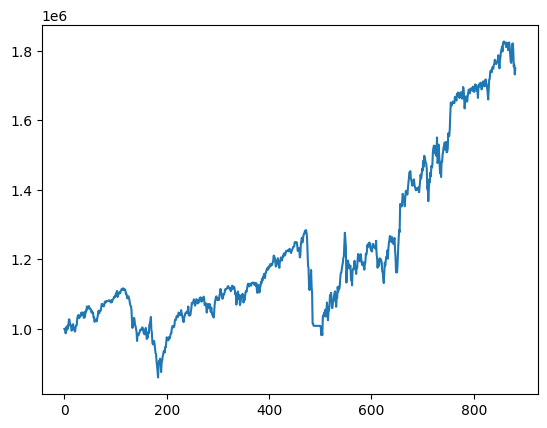

In [10]:
%matplotlib inline
df_account_value.account_value.plot()

In [11]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.173274
Cumulative returns     0.749435
Annual volatility      0.193187
Sharpe ratio           0.925301
Calmar ratio           0.735675
Stability              0.761172
Max drawdown          -0.235530
Omega ratio            1.185167
Sortino ratio          1.309208
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.028872
Daily value at risk   -0.023630
dtype: float64


In [12]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (881, 8)
Annual return          0.099857
Cumulative returns     0.394803
Annual volatility      0.228094
Sharpe ratio           0.532617
Calmar ratio           0.269257
Stability              0.610786
Max drawdown          -0.370862
Omega ratio            1.120620
Sortino ratio          0.734486
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.843505
Daily value at risk   -0.028255
dtype: float64


In [15]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')

df_dji:             date           dji
0    2018-04-04  1.000000e+06
1    2018-04-05  1.009929e+06
2    2018-04-06  9.863363e+05
3    2018-04-09  9.882461e+05
4    2018-04-10  1.005922e+06
..          ...           ...
877  2021-09-27  1.437065e+06
878  2021-09-28  1.413599e+06
879  2021-09-29  1.417338e+06
880  2021-09-30  1.394803e+06
881  2021-10-01           NaN

[882 rows x 2 columns]
df_dji:                       dji
date                    
2018-04-04  1.000000e+06
2018-04-05  1.009929e+06
2018-04-06  9.863363e+05
2018-04-09  9.882461e+05
2018-04-10  1.005922e+06
...                  ...
2021-09-27  1.437065e+06
2021-09-28  1.413599e+06
2021-09-29  1.417338e+06
2021-09-30  1.394803e+06
2021-10-01           NaN

[882 rows x 1 columns]


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:              data
0     2018-01-02
1     2018-01-03
2     2018-01-04
3     2018-01-05
4     2018-01-08
...          ...
1001  2021-12-22
1002  2021-12-23
1003  2021-12-27
1004  2021-12-28
1005  2021-12-29

[1006 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2018-04-04  1.000000e+06
2018-04-05  1.000523e+06
2018-04-06  9.877022e+05
2018-04-09  9.876415e+05
2018-04-10  1.005869e+06
...                  ...
2021-09-27  1.802571e+06
2021-09-28  1.754909e+06
2021-09-29  1.760246e+06
2021-09-30  1.732429e+06
2021-10-01  1.749435e+06

[882 rows x 1 columns]
==============Compare to DJIA===========
result:                  ensemble           dji
date                                  
2018-04-04  1.000000e+06  1.000000e+06
2018-04-05  1.000523e+06  1.009929e+06
2018-04-06  9.877022e+05  9.863363e+05
2018-04-09  9.876415e+05  9.882461e+05
2018-04-10  1.005869e+06  1.005922e+

<Figure size 1500x500 with 0 Axes>

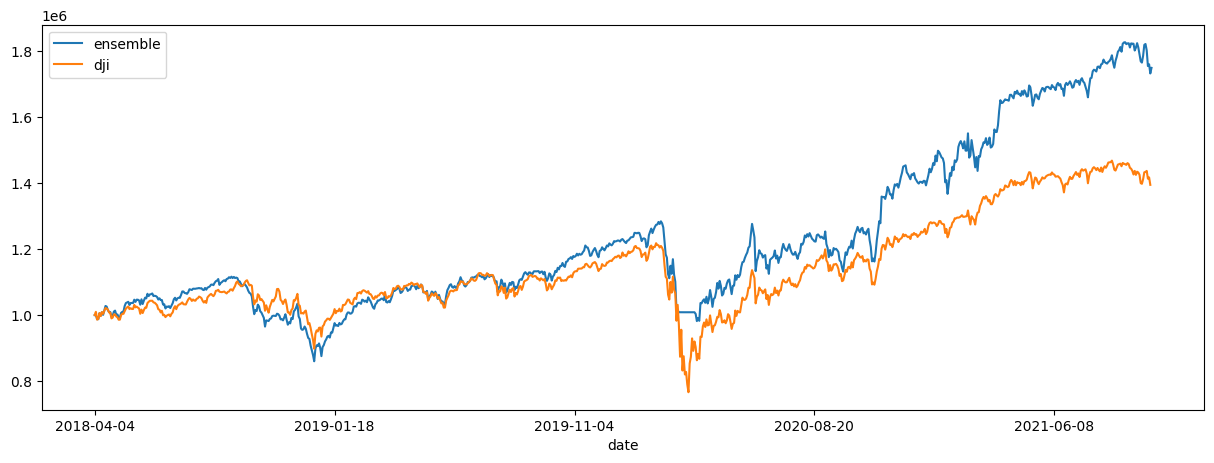

In [16]:
# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();